In [1]:
library("igraph") |> suppressPackageStartupMessages()

Warning message:
"il pacchetto 'igraph' è stato creato con R versione 4.2.3"


# Watts Strogatz - Small world network
We start by investigating the `XY - model` on the Watts strogats network:
```python
dim	
Integer constant, the dimension of the starting lattice.

size	
Integer constant, the size of the lattice along each dimension.

nei	
Integer constant, the neighborhood within which the vertices of the lattice will be connected.

p	
Real constant between zero and one, the rewiring probability.

loops	
Logical scalar, whether loops edges are allowed in the generated graph.

multiple	
Logical scalar, whether multiple edges are allowed int the generated graph.
```

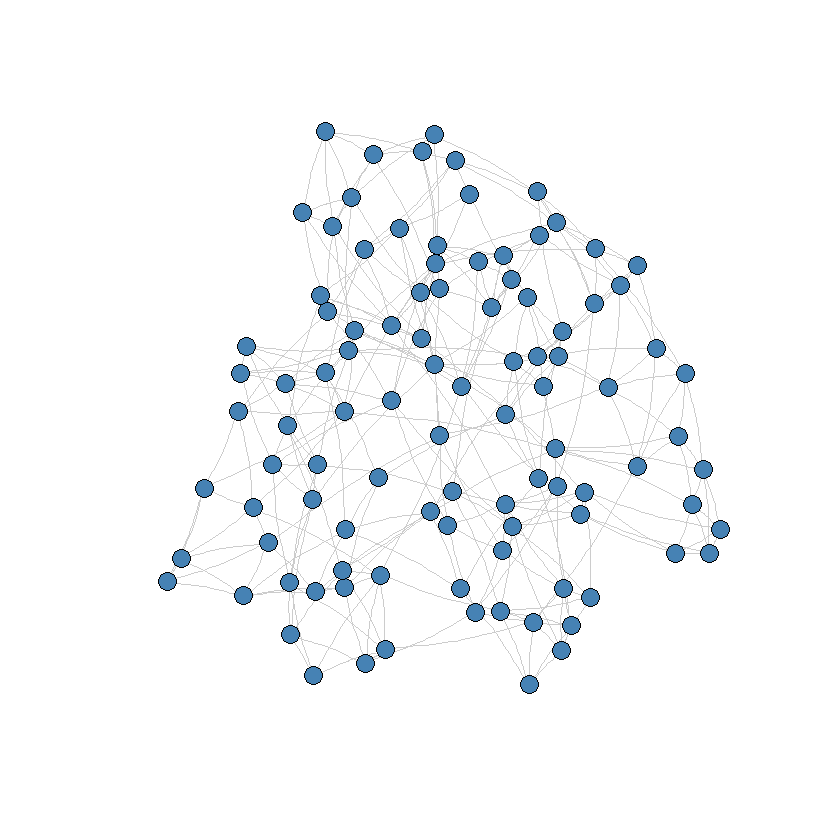

In [2]:
dim <- 1 # 1D
size <- 100
nei <- 3
p <- 0.1
g <- sample_smallworld(dim = dim, size = size, nei = nei, p = p, loops = FALSE, multiple = FALSE)
plot(g, vertex.color="steelblue", edge.curved=0.1, edge.color="gray80", vertex.label=NA, vertex.size=7)

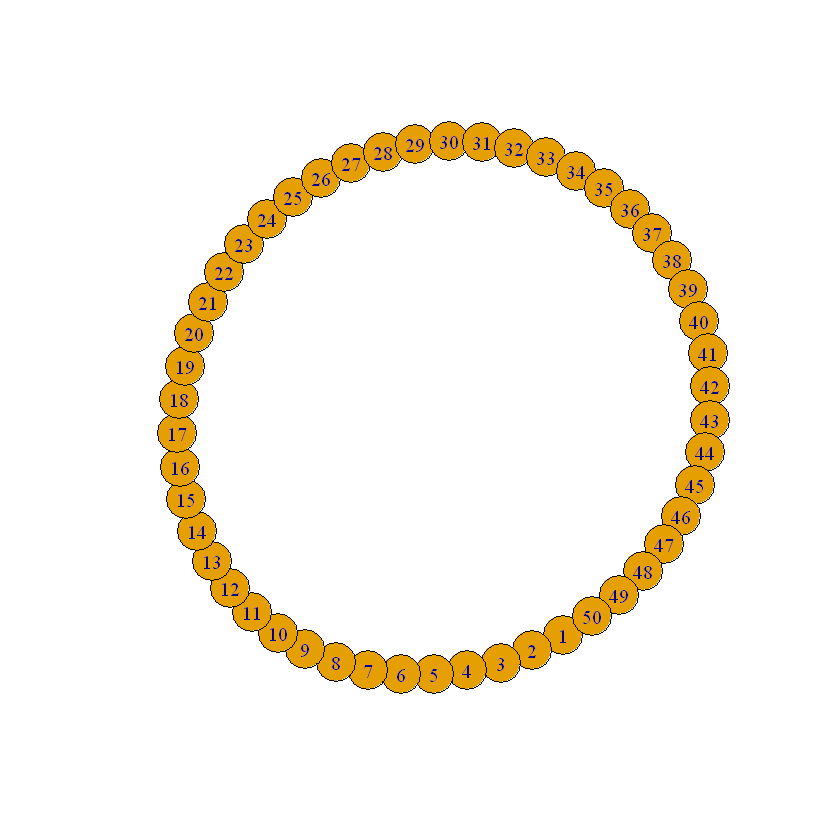

In [3]:
plot(watts.strogatz.game(1, 50, 3, p=0, ))

In [4]:
# Step 1: Generate a Regular Lattice
generate_regular_lattice <- function(dim, size, nei) {
    g <- watts.strogatz.game(dim = dim, size = size, nei = nei, p = 0, loops = FALSE, multiple = FALSE)
    return(g)
}

# Step 2: Rewire Edges
rewire_edges <- function(mat, p, size, nei) {
    l <- (1:size)
    for (k in 1:nei){
        for (i in 1:size){
            # neig <- which(mat[i, l] == 1, arr.ind = TRUE)
            j <- (i + k) %% size
            if (j == 0) {
                j <- 1
            }
            new_pos <- sample(l, 1)
            if (mat[i, new_pos] == 1 || new_pos == i){
                next
            }
            else{
                if (runif(1) < p){
                    mat[i, j] <- 0; mat[j, i] <- 0
                    mat[i, new_pos] <- 1; mat[new_pos, i] <- 1
                }
            }
        } 
    }
    return(mat)
}

# Step 3: Create a Watts-Strogatz Network
create_WS_network <- function(dim, size, nei, p) {
    # Generate a regular lattice
    g <- generate_regular_lattice(dim, size, nei)
    mat <- rewire_edges(get.adjacency(g), p, size, nei)
    # Rewire edges
    adjacency_list <- lapply(1:nrow(mat), function(i) which(mat[i,] == 1))    
    return(adjacency_list)
}

# $\braket{m} = \frac{\braket{M}}{N} = \frac{1}{N}|\braket{\textbf{s}}| = \frac{1}{N}|\braket{\displaystyle\sum_{i=1}^N cos \:\theta_i, \displaystyle\sum_{i=1}^N sin \:\theta_i}|$
## where $N = L \times L $
## $\braket{m^2} = \frac{\braket{M^2}}{N^2} = \frac{1}{N^2}|\braket{s_x^2+s_y^2}| = \frac{1}{N^2}|\braket{\displaystyle(\sum_{i=1}^N cos \:\theta_i)^2 + \displaystyle(\sum_{i=1}^N sin \:\theta_i)^2}|$


In [6]:
H_matrix_calc <- function(N, mat, angles.samples){
    H <- rep(0, N)
    for (i in 1:N){
        for (j in (mat[[i]])){
            # These are all the n.n.
            H[i] <- H[i] - cos(angles.samples[i] - angles.samples[j]) 
        }
    }
    co <- mean(cos(angles.samples))
    si <- mean(sin(angles.samples))
    return(list(H = H, co = co, si = si))
}

In [7]:
compute_delta_H <- function(N, mat, angles.samples, T, H){
    change_pos <- sample(N, 1)
    new_val <- runif(1, -pi/6, pi/6) + angles.samples[change_pos]
    old_val <- angles.samples[change_pos]

    neighbors <- mat[change_pos][[1]]

    old <- - sum(cos(angles.samples[change_pos] - angles.samples[neighbors]))
    new <- - sum(cos(new_val - angles.samples[neighbors]))
    
    delta_H <- new - old

    # Metropolis passage
    if (delta_H < 0 || runif(n = 1, min = 0, max = 1) < exp(-delta_H/T)){
        angles.samples[change_pos] <- new_val
        H <- H + delta_H
    }
    return(list(angles.samples = angles.samples, H = H))
}

In [8]:
get_specific_heat <- function(all_H, T){
    actual.vals <- as.integer(length(all_H)/10)
    len <- length(all_H)
    return(var(all_H[(len-actual.vals):len])/T^2)
}

In [9]:
N <- 100    #, 225, 400)#, 400, 1600, 3200)
Temperature <- seq(2, 2.4, 0.05)
# probs <- seq(0, 1, 0.1)
p <- 0.2
runs <- 1:1000
iter_per_step <- 1:1000
network_realization <- 100
heats <- c(); U.N.T <- c()
for (n in 1:network_realization){
    m <- c(); m.2 <- c(); m.4 <- c()
    specific_heat <- c()

    mat <- create_WS_network(dim = dim, size = N, nei = nei, p = p)
    angles.samples <- runif(n = N, min = -pi, max = pi) 

    result <- H_matrix_calc(N = N, mat = mat, angles.samples = angles.samples)
    H_matrix <- result$H; co <- result$co; si <- result$si
    H <- sum(H_matrix)/2     
    
    for (T in Temperature){
        magn <- c(); all_H <- c(); m_squared <- c(); m_fourth <- c()
        for (run in runs){
            for (iter in iter_per_step){
                res <- compute_delta_H(N, mat, angles.samples, T, H)
                angles.samples <- res$angles.samples; H <- res$H
            }
            co <- mean(cos(angles.samples))
            si <- mean(sin(angles.samples))
            all_H <- append(all_H, H)
            
            # Compute magnetization and higer orders of m
            m_temp <- c(co, si)
            m_2 <- sum(m_temp^2)
            m_4 <- m_2^2

            # Save results for each run
            magn <- append(magn, norm(m_temp, type="2"))
            m_squared <- append(m_squared, m_2)
            m_fourth <- append(m_fourth, m_4) 
        }

        specific_heat <- append(specific_heat, get_specific_heat(all_H, T))
        # Take the average for each run, so to have only one value per temperature
        m <- append(m, mean(magn))
        m.2 <- append(m.2, mean(m_squared))
        m.4 <- append(m.4, mean(m_fourth))
    }
    U.N.T <- append(U.N.T, 1 - m.4/(3*(m.2^2)))
    heats <- append(heats, specific_heat)
}

In [10]:
res_U <- rep(0, length(Temperature))
res_c <- rep(0, length(Temperature))
for (i in 1:length(Temperature)){
    res_U[i] <- mean(U.N.T[seq(i, length(U.N.T), length(Temperature))])
    res_c[i] <- mean(heats[seq(i, length(heats), length(Temperature))])
}

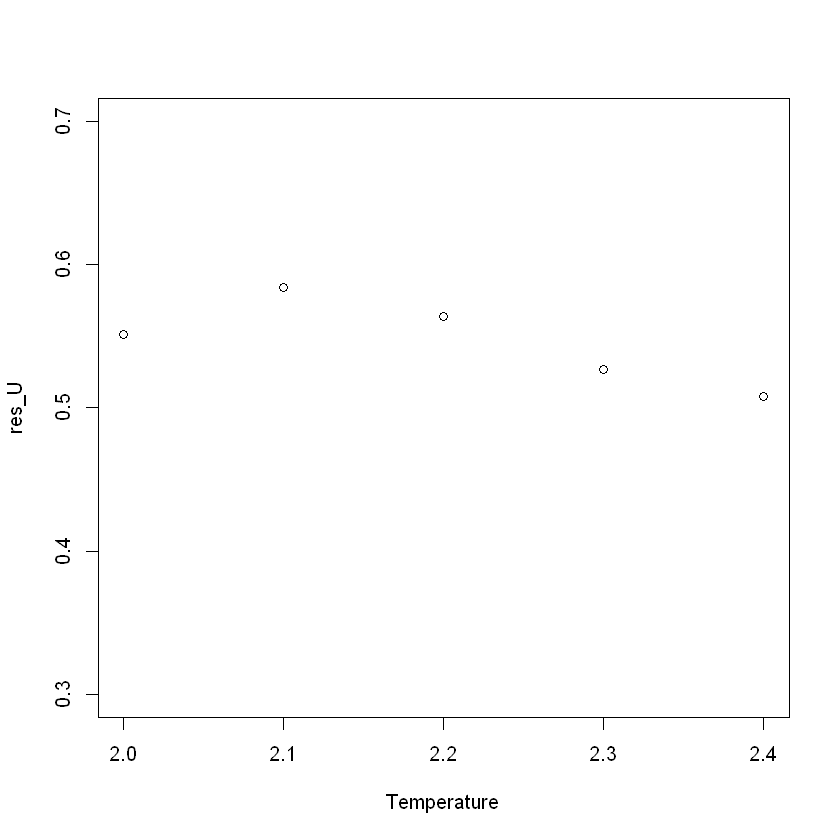

In [11]:
plot(Temperature, res_U, ylim=c(0.3,0.7))

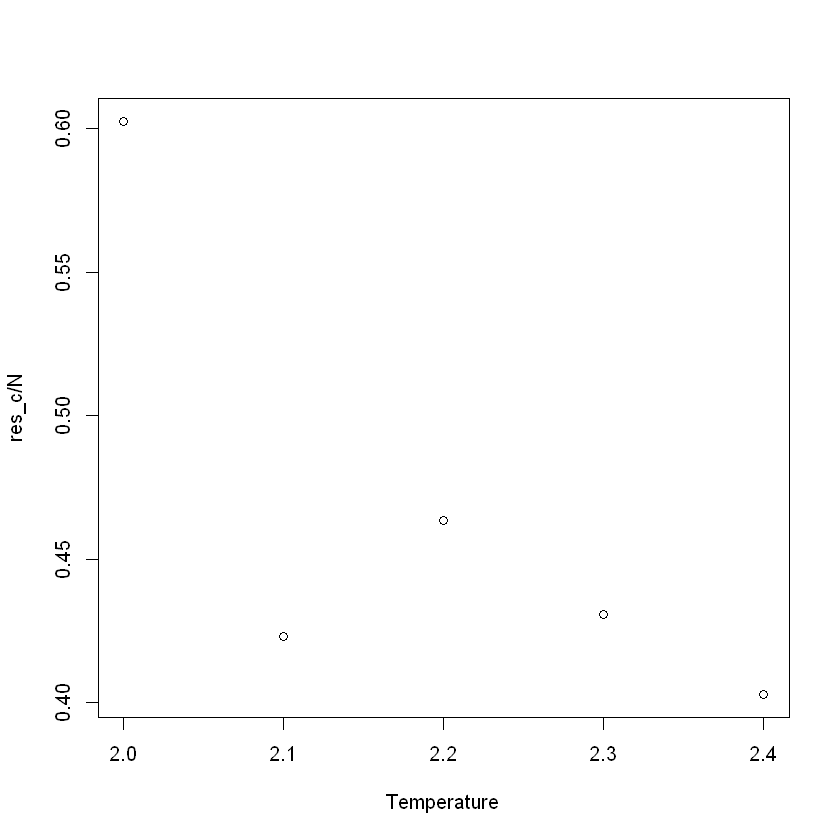

In [12]:
plot(Temperature, res_c/N)
# points(Temperature, specific_heat[(length(Temperature)+1):(2*length(Temperature))], pch=16)
# points(Temperature, specific_heat[(2*length(Temperature)+1):(3*length(Temperature))], pch=16)

In [12]:
folder <- 'res/'
file_path_U <- paste(folder, 'U_', N, '.txt', sep="")
file_path_c <- paste(folder, 'c_', N, '.txt', sep="")
file_path_U; file_path_c

[1] "res/U_200.txt"

[1] "res/c_200.txt"

In [13]:
write.table(res_U, file = file_path_U, col.names = FALSE, row.names = FALSE)
write.table(res_c, file = file_path_c, col.names = FALSE, row.names = FALSE)

In [14]:
U = read.table(file_path_U, header = FALSE, col.names = "U")[[1]]
C = read.table(file_path_c, header = FALSE, col.names = "c")[[1]]

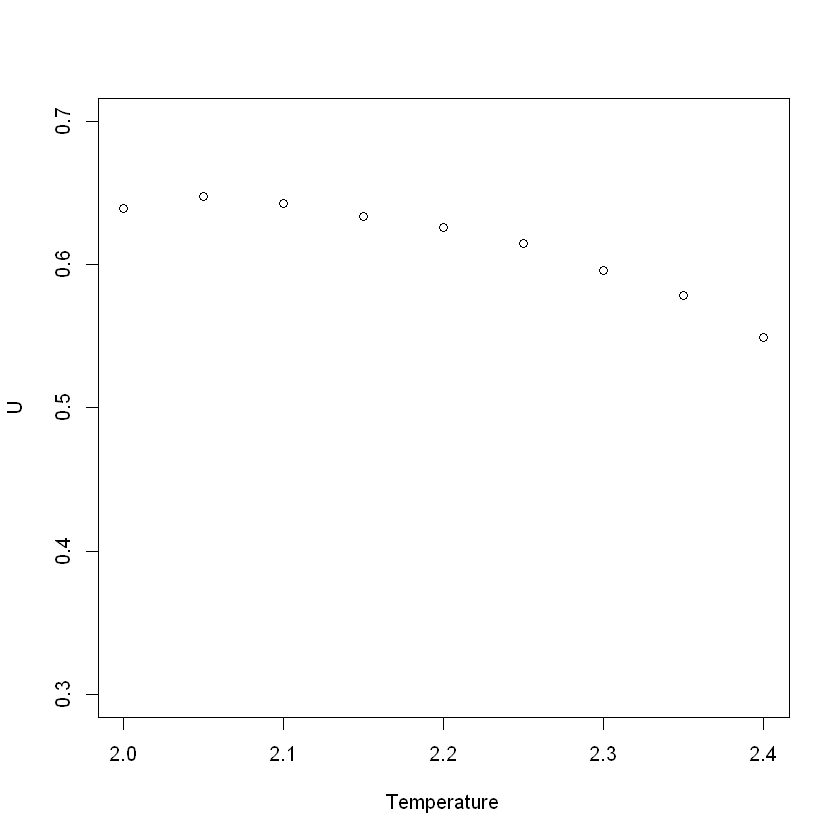

In [17]:
plot(Temperature, U, ylim=c(0.3,0.7))

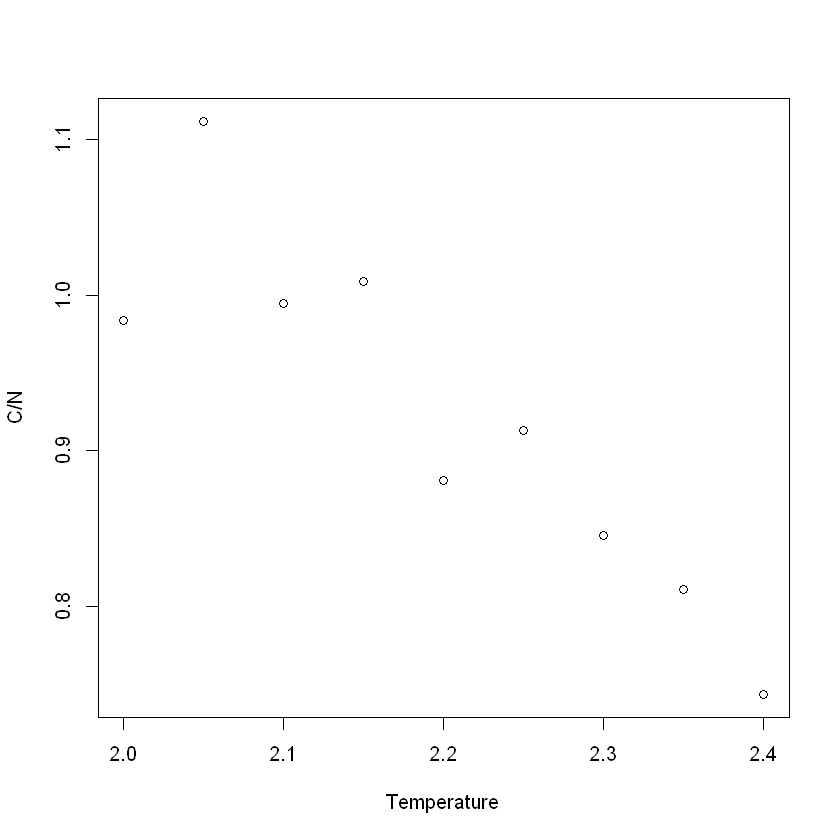

In [16]:
plot(Temperature, C/N)